### Klasifikacija kreditnog rizika - credit scoring classification

Osnovni cilj ovog primjera je upoznavanje sa Python paketima za obradu podataka i mašinsko učenje, sa fokusom na **scikit-learn** i **LightGBM** pakete. U ovom primjeru ćemo koristiti skup podataka **credit-g v.2** koji sadrži informacije o klijentima banke, cilj je klasifikacija klijenata kao dobrih ili loših korisnika kredita.

**Dokumentacija paketa:**
* [pandas docs](https://pandas.pydata.org/docs/)
* [scikit-learn docs](https://scikit-learn.org/stable/)
* [LightGBM docs](https://lightgbm.readthedocs.io/en/stable/)
* [Matplotlib docs](https://matplotlib.org/stable/index.html)
* [seaborn docs](https://seaborn.pydata.org/)

Koristeći sklearn, učitati skup podataka *credit-g v.2* (dataset id=44096), upoznati se sa skupom podataka, analizirati podatke i pripremiti ih za obradu.  
Identifikovati tipove podataka - numeričke i kategoričke.  
Provjeriti da li postoje nedostajuće vrijednosti, ako da, obraditi ih.  
Provjeriti broj jedinstvenih vrijednosti za svaku kolonu.

In [ ]:
import pandas as pd 
from sklearn.datasets import fetch_openml

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OrdinalEncoder,
    StandardScaler,
    LabelEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

In [2]:
credit = fetch_openml(data_id=44096, as_frame=True)

In [3]:
credit_df = credit['data']
credit_df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4,male single,none,4,real estate,67,none,own,2,skilled,1,yes,yes
1,0<=X<200,48,existing paid,radio/tv,5951.0,<100,1<=X<4,2,female div/dep/mar,none,2,real estate,22,none,own,1,skilled,1,none,yes
2,no checking,12,critical/other existing credit,education,2096.0,<100,4<=X<7,2,male single,none,3,real estate,49,none,own,1,unskilled resident,2,none,yes
3,<0,42,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2,male single,guarantor,4,life insurance,45,none,for free,1,skilled,2,none,yes
4,<0,24,delayed previously,new car,4870.0,<100,1<=X<4,3,male single,none,4,no known property,53,none,for free,2,skilled,2,none,yes


In [4]:
credit_df_target = credit["target"]
credit_df_target.head()

0    good
1     bad
2    good
3    good
4     bad
Name: class, dtype: category
Categories (2, object): ['bad', 'good']

In [5]:
print(credit_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   checking_status         1000 non-null   category
 1   duration                1000 non-null   int64   
 2   credit_history          1000 non-null   category
 3   purpose                 1000 non-null   category
 4   credit_amount           1000 non-null   float64 
 5   savings_status          1000 non-null   category
 6   employment              1000 non-null   category
 7   installment_commitment  1000 non-null   int64   
 8   personal_status         1000 non-null   category
 9   other_parties           1000 non-null   category
 10  residence_since         1000 non-null   int64   
 11  property_magnitude      1000 non-null   category
 12  age                     1000 non-null   int64   
 13  other_payment_plans     1000 non-null   category
 14  housing                 1

In [6]:
print(credit_df.isnull().sum())

checking_status           0
duration                  0
credit_history            0
purpose                   0
credit_amount             0
savings_status            0
employment                0
installment_commitment    0
personal_status           0
other_parties             0
residence_since           0
property_magnitude        0
age                       0
other_payment_plans       0
housing                   0
existing_credits          0
job                       0
num_dependents            0
own_telephone             0
foreign_worker            0
dtype: int64


In [7]:
print(credit_df.nunique())

checking_status             4
duration                   33
credit_history              5
purpose                    10
credit_amount             921
savings_status              5
employment                  5
installment_commitment      4
personal_status             4
other_parties               3
residence_since             4
property_magnitude          4
age                        53
other_payment_plans         3
housing                     3
existing_credits            4
job                         4
num_dependents              2
own_telephone               2
foreign_worker              2
dtype: int64


Izdvojiti numeričke i kategoričke kolone.

In [8]:
num_cols = credit_df.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = credit_df.select_dtypes(include=["category"]).columns.tolist()

print(f"Numericke kolone:\n{num_cols}")
print(f"Kategoricke kolone:\n{cat_cols}")

Numericke kolone:
['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
Kategoricke kolone:
['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']


Pregledati jedinstvene vrijednosti za kategoričke kolone.

In [9]:
for col in cat_cols:
    print(f"{col} : {credit_df[col].unique().tolist()}")

checking_status : ['<0', '0<=X<200', 'no checking', '>=200']
credit_history : ['critical/other existing credit', 'existing paid', 'delayed previously', 'no credits/all paid', 'all paid']
purpose : ['radio/tv', 'education', 'furniture/equipment', 'new car', 'used car', 'business', 'domestic appliance', 'repairs', 'other', 'retraining']
savings_status : ['no known savings', '<100', '500<=X<1000', '>=1000', '100<=X<500']
employment : ['>=7', '1<=X<4', '4<=X<7', 'unemployed', '<1']
personal_status : ['male single', 'female div/dep/mar', 'male div/sep', 'male mar/wid']
other_parties : ['none', 'guarantor', 'co applicant']
property_magnitude : ['real estate', 'life insurance', 'no known property', 'car']
other_payment_plans : ['none', 'bank', 'stores']
housing : ['own', 'for free', 'rent']
job : ['skilled', 'unskilled resident', 'high qualif/self emp/mgmt', 'unemp/unskilled non res']
own_telephone : ['yes', 'none']
foreign_worker : ['yes', 'no']


Kreirati preprocessing pipeline koji će:  
    - koristiti StandardScaler za sve numeričke kolone osim 'age' kolone  
    - koristiti OrdinalEncoder za kategoričke kolone  
    - koristiti custom transformer koji će godine klijenta prebaciti u odgovarajuće starosne grupe.  
  
Navedene transformacije je potrebno integrisati u jedan transformer pipeline - koristiti ColumnTransformer.

In [10]:
num_cols_without_age = num_cols.copy()
num_cols_without_age.remove("age")
print(num_cols_without_age)

['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'existing_credits', 'num_dependents']


In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols_without_age),
        (
            "cat",
            OrdinalEncoder(
                handle_unknown="use_encoded_value",
                unknown_value=-1,
                encoded_missing_value=-1,
            ),
            cat_cols,
        ),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [13]:
class AgeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, age_column):
        self.age_column = age_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        age_bins = [0, 18, 25, 35, 45, 55, 65, 70, 100]

        X[self.age_column] = pd.cut(X[self.age_column], bins=age_bins, labels=range(len(age_bins) - 1))
        return X

In [14]:
pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "age",
            AgeTransformer(age_column="age"),
        ),
    ]
)

transformed_credit_df = pipeline.fit_transform(credit_df)
transformed_credit_df.head()

,duration,credit_amount,installment_commitment,residence_since,existing_credits,num_dependents,checking_status,credit_history,purpose,savings_status,employment,personal_status,other_parties,property_magnitude,other_payment_plans,housing,job,own_telephone,foreign_worker,age
0,-1.236478,-0.745131,0.918477,1.046987,1.027079,-0.428290,1.0,1.0,6.0,4.0,3.0,3.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,6
1,2.248194,0.949817,-0.870183,-0.765977,-0.704926,-0.428290,0.0,3.0,6.0,2.0,0.0,0.0,2.0,3.0,1.0,1.0,1.0,0.0,1.0,1
2,-0.738668,-0.416562,-0.870183,0.140505,-0.704926,2.334869,3.0,1.0,2.0,2.0,1.0,3.0,2.0,3.0,1.0,1.0,3.0,0.0,1.0,4
3,1.750384,1.634247,-0.870183,1.046987,-0.704926,2.334869,1.0,3.0,3.0,2.0,1.0,3.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,3
4,0.256953,0.566664,0.024147,1.046987,1.027079,2.334869,1.0,2.0,4.0,2.0,0.0,3.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,4


Enkodirati ciljanu varijablu koristeći LabelEncoder.

In [15]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(credit_df_target)
y = pd.Series(y_encoded, name="target")

Dodati ciljanu varijablu u skup podataka i izračunati matricu korelacije.

In [16]:
df_with_target = transformed_credit_df.copy()
df_with_target["target"] = y

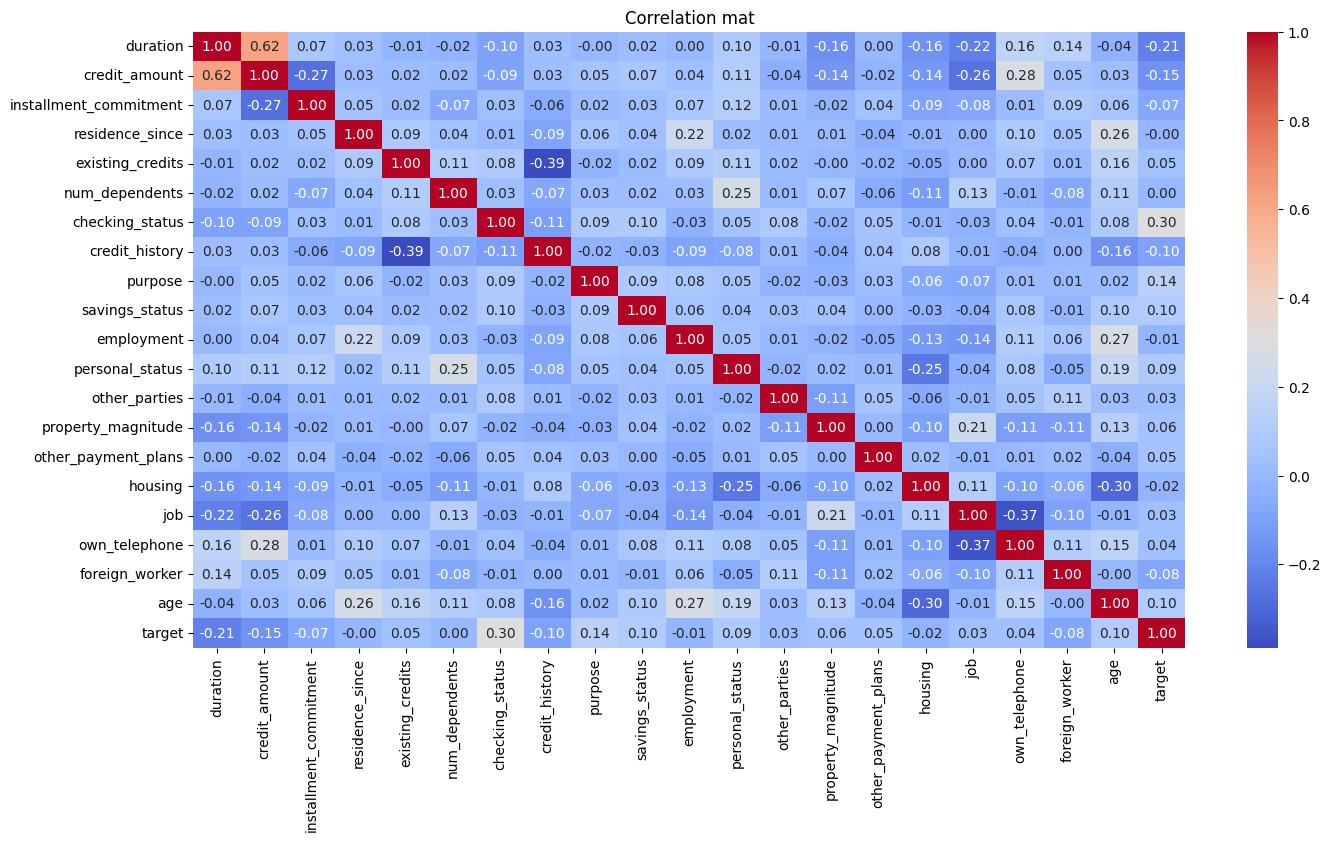

In [ ]:
cor_mat = df_with_target.corr()

plt.figure(figsize=(16, 8))
sns.heatmap(cor_mat, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation mat")
plt.show()

Analizirati korelacije u odnosu na ciljanu varijablu i izdvojiti 4 najveće i 4 najmanje korelacije.

In [18]:
target_correlations = cor_mat["target"].sort_values(ascending=False)
print("Correlation:")
print(target_correlations)

Correlation:
target                    1.000000
checking_status           0.302406
purpose                   0.138152
age                       0.103400
savings_status            0.103133
personal_status           0.089535
property_magnitude        0.055529
other_payment_plans       0.053862
existing_credits          0.045732
own_telephone             0.036466
job                       0.032756
other_parties             0.028441
num_dependents            0.003015
residence_since          -0.002967
employment               -0.008932
housing                  -0.019315
installment_commitment   -0.072404
foreign_worker           -0.082079
credit_history           -0.097054
credit_amount            -0.154739
duration                 -0.214927
Name: target, dtype: float64


In [19]:
threshold = 0.06
selected_features = target_correlations[
    abs(target_correlations) > threshold 
].index.tolist()
selected_features.remove("target")

print(selected_features)

['checking_status', 'purpose', 'age', 'savings_status', 'personal_status', 'installment_commitment', 'foreign_worker', 'credit_history', 'credit_amount', 'duration']


Podijeliti podatke na skup za treniranje i testiranje

In [20]:
X = transformed_credit_df[selected_features]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=42
)

Izvršiti treniranje LightGBM modela i prikazati rezultat evaluacije modela koristeći 'accuracy_score'.

In [21]:
model = lgb.LGBMClassifier(num_leaves=8, max_depth=4, random_state=42, n_jobs=12)
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 455, number of negative: 195
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 650, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.700000 -> initscore=0.847298
[LightGBM] [Info] Start training from score 0.847298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LGBMClassifier(max_depth=4, n_jobs=12, num_leaves=8, random_state=42)

In [22]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {accuracy:.3f}")

Accuracy score: 0.783


Koristeći scikit-learn model_selection.GridSearchCV, optimizirati parametre LightGBM modela.

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


lgb_model = lgb.LGBMClassifier(random_state=42, n_jobs=12)

param_grid = {
    "num_leaves": [4, 5, 6, 7],
    "learning_rate": [0.1, 0.01],
    "max_depth": [3, 4, 5, 6],
    "n_estimators": [200, 500, 1000],
}

grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring=make_scorer(accuracy_score),
    n_jobs=12,
    cv=5,
    verbose=1,
)

grid_search.fit(X_train, y_train)

print(f"Best parameters found: {grid_search.best_params_}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[LightGBM] [Info] Number of positive: 455, number of negative: 195
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 650, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.700000 -> initscore=0.847298
[LightGBM] [Info] Start training from score 0.847298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [24]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score of the best model: {accuracy}")

Accuracy score of the best model: 0.7771428571428571
